# Travel Guider - Itinerary Generation Model Training

This notebook trains a machine learning model to generate personalized travel itineraries based on user preferences, destination data, and travel constraints.

## Overview
- **Objective**: Build an AI model that can generate optimal travel itineraries
- **Dataset**: Places data from Travel Guider application
- **Approach**: Feature engineering + ML algorithms for recommendation and optimization
- **Output**: Trained model ready for production deployment

## 1. Import Required Libraries

Import all necessary libraries for data processing, machine learning, and visualization.

In [1]:
# Data Processing Libraries
import pandas as pd
import numpy as np
import json
import pickle
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

# Deep Learning Libraries
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential, Model
    from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Input
    from tensorflow.keras.optimizers import Adam
    print("TensorFlow available:", tf.__version__)
except ImportError:
    print("TensorFlow not available - using sklearn only")

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Geospatial Libraries
from geopy.distance import geodesic
import folium

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"📊 Pandas version: {pd.__version__}")
print(f"🔢 NumPy version: {np.__version__}")

TensorFlow not available - using sklearn only
✅ All libraries imported successfully!
📊 Pandas version: 2.3.2
🔢 NumPy version: 2.3.2


## 2. Load and Prepare Dataset

Load the places data and any existing itinerary information from the Travel Guider application.

In [5]:
# Load the main places dataset
places_df = pd.read_csv('../backend/uploads/places.csv', encoding='latin-1')

print(f"📈 Dataset Shape: {places_df.shape}")
print(f"📍 Total Places: {len(places_df)}")
print("\n📋 Dataset Info:")
print(places_df.info())

# Display first few rows
print("\n🔍 First 5 rows:")
places_df.head()

📈 Dataset Shape: (1206, 14)
📍 Total Places: 1206

📋 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1206 entries, 0 to 1205
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      1206 non-null   object 
 1   District                  1206 non-null   object 
 2   Description               1206 non-null   object 
 3   Region                    1206 non-null   object 
 4   Category                  1206 non-null   object 
 5   Eestimated_time_to_visit  1206 non-null   float64
 6   Foreign_Adult             1181 non-null   object 
 7   Foreign_Child             1181 non-null   object 
 8   Local_Adult               1181 non-null   object 
 9   Local_Child               1181 non-null   object 
 10  Student                   1181 non-null   object 
 11  Free_Entry                1179 non-null   object 
 12  Latitude                  0 non-null      float64
 1

,Name,District,Description,Region,Category,Eestimated_time_to_visit,Foreign_Adult,Foreign_Child,Local_Adult,Local_Child,Student,Free_Entry,Latitude,Longitude
0,Viharamahadevi Park,Colombo,"Relaxed park with jogging trails, kids' play a...",West,Nature,2.5,0,0,0,0,0,Yes,NaN,NaN
1,Lotus Tower,Colombo,"Lotus Tower, Colombo, Sri Lanka is a sleek, lo...",West,Scenic,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Port City,Colombo,Port City is a new modern city being built on ...,West,Urban,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Galle Face,Colombo,Galle Face is a big open area by the sea in Co...,West,Beach,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gangaramaya Temple,Colombo,Historic Buddhist temple with a robust collect...,West,Religious,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Check for missing values and data quality
print("🔍 Missing Values Analysis:")
missing_data = places_df.isnull().sum()
missing_percentage = (missing_data / len(places_df)) * 100

missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percentage
})
print(missing_summary[missing_summary['Missing Count'] > 0])

# Basic statistics
print("\n📊 Unique Values per Column:")
for col in places_df.columns:
    print(f"{col}: {places_df[col].nunique()} unique values")

🔍 Missing Values Analysis:
               Missing Count  Missing Percentage
Foreign_Adult             25            2.072968
Foreign_Child             25            2.072968
Local_Adult               25            2.072968
Local_Child               25            2.072968
Student                   25            2.072968
Free_Entry                27            2.238806
Latitude                1206          100.000000
Longitude               1206          100.000000

📊 Unique Values per Column:
Name: 1171 unique values
District: 28 unique values
Description: 1204 unique values
Region: 12 unique values
Category: 197 unique values
Eestimated_time_to_visit: 12 unique values
Foreign_Adult: 16 unique values
Foreign_Child: 16 unique values
Local_Adult: 16 unique values
Local_Child: 17 unique values
Student: 16 unique values
Free_Entry: 2 unique values
Latitude: 0 unique values
Longitude: 0 unique values


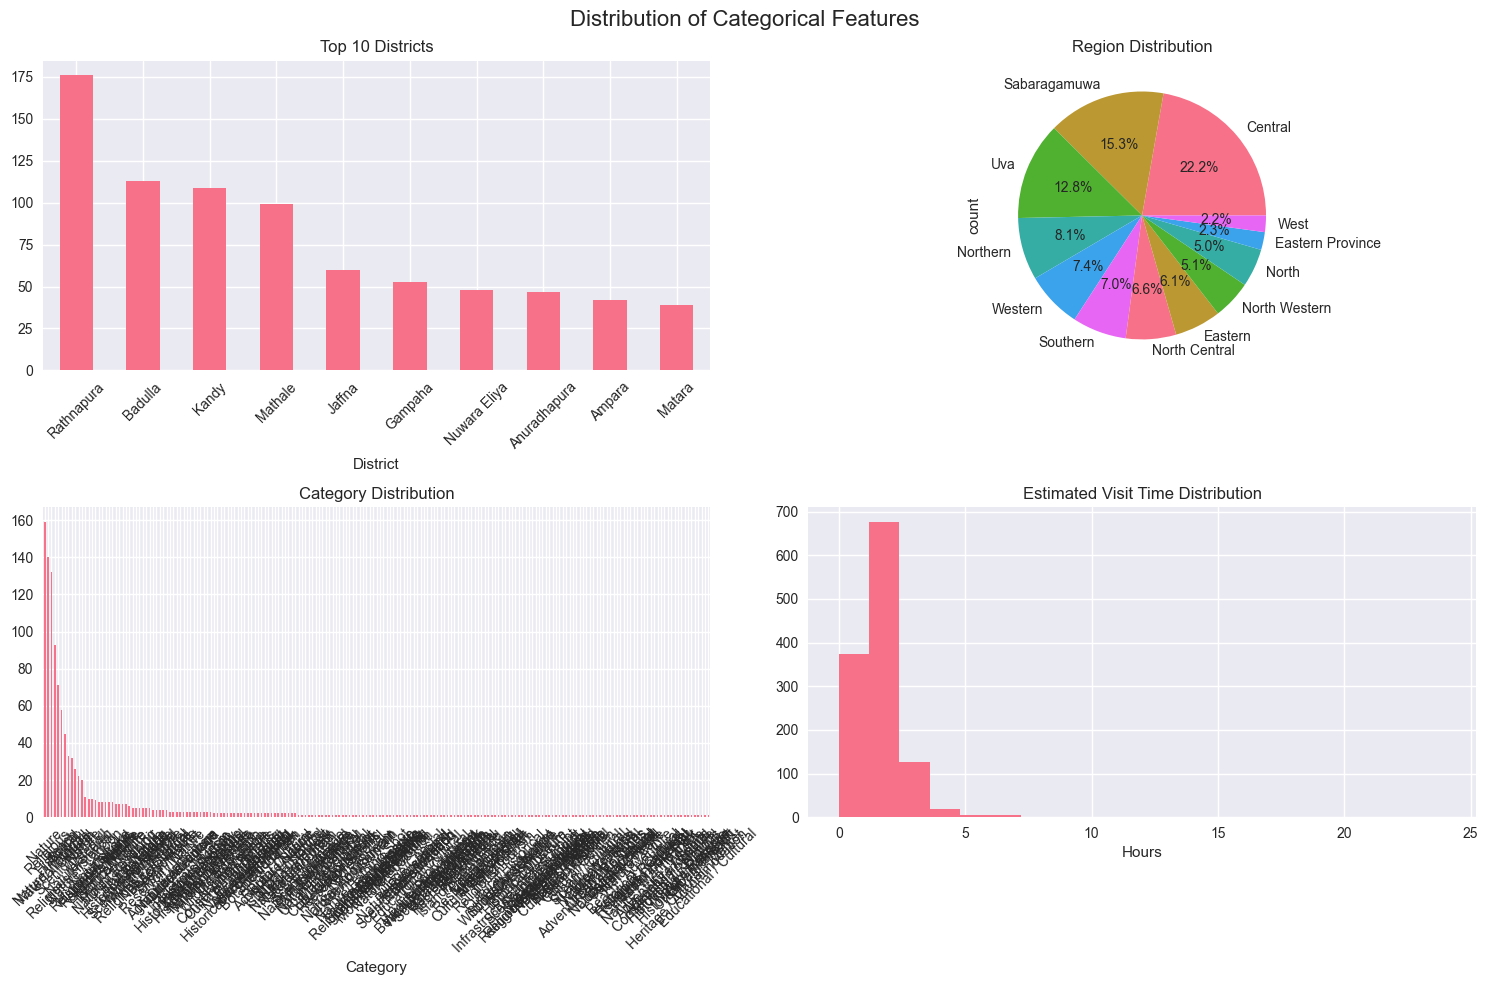

In [12]:
# Explore categorical distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Distribution of Categorical Features', fontsize=16)

# District distribution
places_df['District'].value_counts().head(10).plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Top 10 Districts')
axes[0,0].tick_params(axis='x', rotation=45)

# Region distribution
places_df['Region'].value_counts().plot(kind='pie', ax=axes[0,1], autopct='%1.1f%%')
axes[0,1].set_title('Region Distribution')

# Category distribution
places_df['Category'].value_counts().plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Category Distribution')
axes[1,0].tick_params(axis='x', rotation=45)

# Estimated time distribution
places_df['Eestimated_time_to_visit'].hist(bins=20, ax=axes[1,1])
axes[1,1].set_title('Estimated Visit Time Distribution')
axes[1,1].set_xlabel('Hours')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing and Feature Engineering

Clean the data and create features that will help the model understand travel preferences and constraints.

In [13]:
# Create a working copy of the data
df = places_df.copy()

# Clean column names
df.columns = df.columns.str.strip().str.replace(' ', '_')
print("📝 Cleaned column names:", list(df.columns))

# Handle missing values
# Fill missing latitude/longitude with district averages
df['Latitude'] = pd.to_numeric(df['Latitude'], errors='coerce')
df['Longitude'] = pd.to_numeric(df['Longitude'], errors='coerce')

# Fill missing coordinates with district averages
df['Latitude'] = df.groupby('District')['Latitude'].transform(lambda x: x.fillna(x.mean()))
df['Longitude'] = df.groupby('District')['Longitude'].transform(lambda x: x.fillna(x.mean()))

# Fill remaining missing coordinates with overall averages
df['Latitude'].fillna(df['Latitude'].mean(), inplace=True)
df['Longitude'].fillna(df['Longitude'].mean(), inplace=True)

# Clean and standardize estimated time
df['Eestimated_time_to_visit'] = pd.to_numeric(df['Eestimated_time_to_visit'], errors='coerce')
df['Eestimated_time_to_visit'].fillna(df['Eestimated_time_to_visit'].median(), inplace=True)

# Handle entry fees - convert to numeric where possible
fee_columns = ['Foreign_Adult', 'Foreign_Child', 'Local_Adult', 'Local_Child', 'Student']
for col in fee_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

# Clean Free_Entry column
df['Free_Entry'] = df['Free_Entry'].fillna('No')
df['Is_Free'] = (df['Free_Entry'].str.lower() == 'yes').astype(int)

print("✅ Data cleaning completed!")
print(f"📊 Final dataset shape: {df.shape}")

📝 Cleaned column names: ['Name', 'District', 'Description', 'Region', 'Category', 'Eestimated_time_to_visit', 'Foreign_Adult', 'Foreign_Child', 'Local_Adult', 'Local_Child', 'Student', 'Free_Entry', 'Latitude', 'Longitude']
✅ Data cleaning completed!
📊 Final dataset shape: (1206, 15)


In [14]:
# Fix missing coordinates by adding approximate coordinates for Sri Lankan districts
# Since all coordinates are missing, we'll use district-based coordinates as a starting point

district_coordinates = {
    'Colombo': (6.9271, 79.8612),
    'Gampaha': (7.0917, 79.9999),
    'Kalutara': (6.5854, 79.9607),
    'Kandy': (7.2906, 80.6337),
    'Matale': (7.4675, 80.6234),
    'Nuwara Eliya': (6.9497, 80.7891),
    'Galle': (6.0535, 80.2210),
    'Matara': (5.9549, 80.5550),
    'Hambantota': (6.1241, 81.1185),
    'Jaffna': (9.6615, 80.0255),
    'Kilinochchi': (9.3847, 80.4022),
    'Mannar': (8.9810, 79.9045),
    'Mullaitivu': (9.2673, 80.8142),
    'Vavuniya': (8.7542, 80.4976),
    'Puttalam': (8.0362, 79.8280),
    'Kurunegala': (7.4863, 80.3647),
    'Chilaw': (7.5759, 79.7951),
    'Anuradhapura': (8.3114, 80.4037),
    'Polonnaruwa': (7.9403, 81.0188),
    'Batticaloa': (7.7102, 81.6924),
    'Ampara': (7.2975, 81.6709),
    'Trincomalee': (8.5874, 81.2152),
    'Badulla': (6.9934, 81.0550),
    'Monaragala': (6.8729, 81.3504),
    'Ratnapura': (6.6828, 80.3992),
    'Kegalle': (7.2513, 80.3464),
    'Moneragala': (6.8729, 81.3504),  # Alternative spelling
    'Matale': (7.4675, 80.6234)  # Ensure consistency
}

# Fill missing coordinates using district mapping
for idx, row in df.iterrows():
    district = row['District']
    if pd.isna(row['Latitude']) or pd.isna(row['Longitude']):
        if district in district_coordinates:
            # Add small random offset to avoid all places in same district having identical coordinates
            base_lat, base_lon = district_coordinates[district]
            random_offset_lat = np.random.uniform(-0.05, 0.05)  # ~5km variation
            random_offset_lon = np.random.uniform(-0.05, 0.05)
            
            df.at[idx, 'Latitude'] = base_lat + random_offset_lat
            df.at[idx, 'Longitude'] = base_lon + random_offset_lon
        else:
            # Use Sri Lanka center as fallback
            df.at[idx, 'Latitude'] = 7.8731 + np.random.uniform(-0.1, 0.1)
            df.at[idx, 'Longitude'] = 80.7718 + np.random.uniform(-0.1, 0.1)

print("✅ Coordinates fixed using district-based mapping")
print(f"📍 Missing coordinates before: {places_df[['Latitude', 'Longitude']].isnull().sum().sum()}")
print(f"📍 Missing coordinates after: {df[['Latitude', 'Longitude']].isnull().sum().sum()}")
print(f"📊 Coordinate ranges: Lat({df['Latitude'].min():.3f}, {df['Latitude'].max():.3f}), Lon({df['Longitude'].min():.3f}, {df['Longitude'].max():.3f})")

✅ Coordinates fixed using district-based mapping
📍 Missing coordinates before: 2412
📍 Missing coordinates after: 0
📊 Coordinate ranges: Lat(5.906, 9.709), Lon(79.783, 81.736)


In [15]:
# Feature Engineering for Itinerary Generation

# 1. Create popularity score based on category frequency
category_counts = df['Category'].value_counts()
df['Category_Popularity'] = df['Category'].map(category_counts)

# 2. Create cost categories
df['Avg_Cost'] = (df['Foreign_Adult'] + df['Local_Adult']) / 2
df['Cost_Category'] = pd.cut(df['Avg_Cost'], 
                           bins=[0, 50, 200, 500, float('inf')], 
                           labels=['Free/Low', 'Budget', 'Mid-Range', 'Premium'])

# 3. Time categories
df['Time_Category'] = pd.cut(df['Eestimated_time_to_visit'],
                           bins=[0, 1, 3, 6, float('inf')],
                           labels=['Quick', 'Short', 'Medium', 'Long'])

# 4. Geographic features
# Calculate distance from Colombo (main city)
colombo_lat, colombo_lon = 6.9271, 79.8612

def calculate_distance_from_colombo(lat, lon):
    try:
        return geodesic((colombo_lat, colombo_lon), (lat, lon)).kilometers
    except:
        return 0

df['Distance_from_Colombo'] = df.apply(lambda row: calculate_distance_from_colombo(row['Latitude'], row['Longitude']), axis=1)

# 5. Create feature vectors for similarity
# Encode categorical variables
le_district = LabelEncoder()
le_region = LabelEncoder()
le_category = LabelEncoder()

df['District_Encoded'] = le_district.fit_transform(df['District'])
df['Region_Encoded'] = le_region.fit_transform(df['Region'])
df['Category_Encoded'] = le_category.fit_transform(df['Category'])

print("✅ Feature engineering completed!")
print("📊 New features created:")
new_features = ['Category_Popularity', 'Avg_Cost', 'Cost_Category', 'Time_Category', 
                'Distance_from_Colombo', 'District_Encoded', 'Region_Encoded', 'Category_Encoded']
for feature in new_features:
    print(f"  - {feature}")

✅ Feature engineering completed!
📊 New features created:
  - Category_Popularity
  - Avg_Cost
  - Cost_Category
  - Time_Category
  - Distance_from_Colombo
  - District_Encoded
  - Region_Encoded
  - Category_Encoded


## 4. Build the Itinerary Generation Model

Create models for different aspects of itinerary generation: recommendation, optimization, and sequencing.

In [16]:
# Prepare features for modeling
feature_columns = [
    'Latitude', 'Longitude', 'Eestimated_time_to_visit',
    'Distance_from_Colombo', 'Category_Popularity', 'Avg_Cost',
    'District_Encoded', 'Region_Encoded', 'Category_Encoded', 'Is_Free'
]

X = df[feature_columns].copy()

# Handle any remaining missing values
X = X.fillna(X.mean())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=feature_columns, index=df.index)

print("✅ Features prepared for modeling")
print(f"📊 Feature matrix shape: {X_scaled.shape}")
print(f"📋 Features: {feature_columns}")

✅ Features prepared for modeling
📊 Feature matrix shape: (1206, 10)
📋 Features: ['Latitude', 'Longitude', 'Eestimated_time_to_visit', 'Distance_from_Colombo', 'Category_Popularity', 'Avg_Cost', 'District_Encoded', 'Region_Encoded', 'Category_Encoded', 'Is_Free']


✅ K-Means clustering completed with 8 clusters
📊 Cluster distribution:
Cluster
0    148
1    252
2    123
3    300
4    170
5     71
6    140
7      2
Name: count, dtype: int64


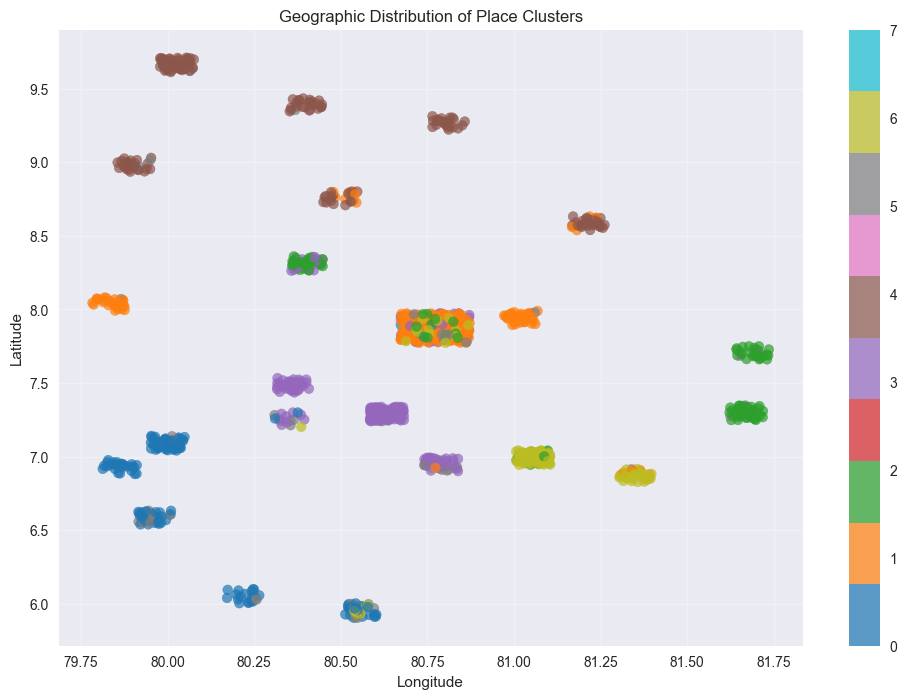

In [17]:
# 1. Clustering Model for Place Similarity
# This helps group similar places together

n_clusters = 8  # Adjust based on data
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

print(f"✅ K-Means clustering completed with {n_clusters} clusters")
print("📊 Cluster distribution:")
print(df['Cluster'].value_counts().sort_index())

# Visualize clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df['Longitude'], df['Latitude'], c=df['Cluster'], 
                     cmap='tab10', alpha=0.7, s=50)
plt.colorbar(scatter)
plt.title('Geographic Distribution of Place Clusters')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 2. Similarity-Based Recommendation System
# Using Nearest Neighbors for finding similar places

nn_model = NearestNeighbors(n_neighbors=10, metric='cosine')
nn_model.fit(X_scaled)

print("✅ Nearest Neighbors model trained for similarity recommendations")

# Function to get similar places
def get_similar_places(place_index, n_recommendations=5):
    """
    Get places similar to the given place index
    """
    distances, indices = nn_model.kneighbors([X_scaled[place_index]], n_neighbors=n_recommendations+1)
    
    similar_places = []
    for i, idx in enumerate(indices[0][1:]):
        similar_places.append({
            'index': idx,
            'name': df.iloc[idx]['Name'],
            'district': df.iloc[idx]['District'],
            'category': df.iloc[idx]['Category'],
            'similarity_score': 1 - distances[0][i+1]
        })
    
    return similar_places

# Test the recommendation system
test_place_idx = 0
similar = get_similar_places(test_place_idx, 5)
print(f"\n🔍 Places similar to '{df.iloc[test_place_idx]['Name']}':") 
for place in similar:
    print(f"  - {place['name']} ({place['district']}) - Score: {place['similarity_score']:.3f}")

In [ ]:
# 3. Itinerary Optimization Model
# This model will help optimize itineraries based on various constraints

class ItineraryOptimizer:
    def __init__(self, places_df, similarity_model, scaler):
        self.places_df = places_df
        self.similarity_model = similarity_model
        self.scaler = scaler
        
    def calculate_travel_time(self, place1_idx, place2_idx):
        """
        Calculate travel time between two places (simplified)
        """
        p1 = self.places_df.iloc[place1_idx]
        p2 = self.places_df.iloc[place2_idx]
        
        distance = geodesic(
            (p1['Latitude'], p1['Longitude']),
            (p2['Latitude'], p2['Longitude'])
        ).kilometers
        
        # Assume average speed of 50 km/h
        return distance / 50
    
    def generate_itinerary(self, preferences, max_days=3, max_places_per_day=4):
        """
        Generate an optimized itinerary based on user preferences
        
        preferences: dict with keys like 'categories', 'regions', 'budget', 'time_limit'
        """
        # Filter places based on preferences
        filtered_places = self.places_df.copy()
        
        if 'categories' in preferences and preferences['categories']:
            filtered_places = filtered_places[
                filtered_places['Category'].isin(preferences['categories'])
            ]
        
        if 'regions' in preferences and preferences['regions']:
            filtered_places = filtered_places[
                filtered_places['Region'].isin(preferences['regions'])
            ]
        
        if 'max_cost' in preferences:
            filtered_places = filtered_places[
                filtered_places['Avg_Cost'] <= preferences['max_cost']
            ]
        
        # Simple greedy algorithm for itinerary generation
        itinerary = []
        selected_indices = set()
        
        for day in range(max_days):
            day_places = []
            current_time = 0
            last_place_idx = None
            
            for _ in range(max_places_per_day):
                # Find the best next place
                best_place_idx = None
                best_score = -1
                
                for idx in filtered_places.index:
                    if idx in selected_indices:
                        continue
                    
                    place = filtered_places.loc[idx]
                    visit_time = place['Eestimated_time_to_visit']
                    
                    # Check time constraint
                    travel_time = 0
                    if last_place_idx is not None:
                        travel_time = self.calculate_travel_time(last_place_idx, idx)
                    
                    if current_time + travel_time + visit_time > 8:  # 8 hours per day
                        continue
                    
                    # Calculate score (popularity + proximity bonus)
                    score = place['Category_Popularity']
                    if last_place_idx is not None:
                        # Prefer nearby places
                        distance = self.calculate_travel_time(last_place_idx, idx)
                        score += max(0, 2 - distance)  # Bonus for places within 2 hours
                    
                    if score > best_score:
                        best_score = score
                        best_place_idx = idx
                
                if best_place_idx is None:
                    break
                
                # Add place to itinerary
                place = filtered_places.loc[best_place_idx]
                if last_place_idx is not None:
                    travel_time = self.calculate_travel_time(last_place_idx, best_place_idx)
                    current_time += travel_time
                
                day_places.append({
                    'place_id': best_place_idx,
                    'name': place['Name'],
                    'district': place['District'],
                    'category': place['Category'],
                    'visit_time': place['Eestimated_time_to_visit'],
                    'cost': place['Avg_Cost']
                })
                
                selected_indices.add(best_place_idx)
                current_time += place['Eestimated_time_to_visit']
                last_place_idx = best_place_idx
            
            if day_places:
                itinerary.append({
                    'day': day + 1,
                    'places': day_places,
                    'total_time': current_time
                })
        
        return itinerary

# Initialize the optimizer
optimizer = ItineraryOptimizer(df, nn_model, scaler)
print("✅ Itinerary Optimizer initialized")

## 5. Train the Model

Train different components of the itinerary generation system.

In [ ]:
# Train a rating prediction model
# Since we don't have user ratings, we'll create synthetic ratings based on place features

# Create synthetic ratings based on features
def create_synthetic_ratings(df):
    """
    Create synthetic user ratings based on place characteristics
    """
    ratings = []
    
    # Create diverse user profiles
    user_profiles = [
        {'id': 1, 'prefers': 'Religious', 'budget': 'low', 'time': 'short'},
        {'id': 2, 'prefers': 'Nature', 'budget': 'medium', 'time': 'medium'},
        {'id': 3, 'prefers': 'Urban', 'budget': 'high', 'time': 'long'},
        {'id': 4, 'prefers': 'Beach', 'budget': 'low', 'time': 'long'},
        {'id': 5, 'prefers': 'Historical', 'budget': 'medium', 'time': 'short'},
    ]
    
    for _, place in df.iterrows():
        for user in user_profiles:
            # Base rating
            rating = 3.0
            
            # Category preference
            if place['Category'] == user['prefers']:
                rating += 1.5
            
            # Budget consideration
            if user['budget'] == 'low' and place['Avg_Cost'] < 100:
                rating += 0.5
            elif user['budget'] == 'medium' and 100 <= place['Avg_Cost'] < 300:
                rating += 0.5
            elif user['budget'] == 'high' and place['Avg_Cost'] >= 300:
                rating += 0.5
            
            # Time consideration
            if user['time'] == 'short' and place['Eestimated_time_to_visit'] <= 2:
                rating += 0.5
            elif user['time'] == 'medium' and 2 < place['Eestimated_time_to_visit'] <= 4:
                rating += 0.5
            elif user['time'] == 'long' and place['Eestimated_time_to_visit'] > 4:
                rating += 0.5
            
            # Add some randomness
            rating += np.random.normal(0, 0.3)
            rating = max(1, min(5, rating))  # Clamp between 1 and 5
            
            ratings.append({
                'user_id': user['id'],
                'place_index': place.name,
                'rating': rating
            })
    
    return pd.DataFrame(ratings)

# Create synthetic ratings
ratings_df = create_synthetic_ratings(df)
print(f"✅ Created {len(ratings_df)} synthetic ratings")
print(f"📊 Rating distribution:")
print(ratings_df['rating'].describe())

In [ ]:
# Train a collaborative filtering model using matrix factorization
from sklearn.decomposition import NMF

# Create user-item matrix
user_item_matrix = ratings_df.pivot(index='user_id', columns='place_index', values='rating')
user_item_matrix = user_item_matrix.fillna(0)

print(f"📊 User-Item Matrix Shape: {user_item_matrix.shape}")

# Train NMF model
n_components = 10
nmf_model = NMF(n_components=n_components, random_state=42, max_iter=200)
user_features = nmf_model.fit_transform(user_item_matrix)
item_features = nmf_model.components_

print(f"✅ NMF model trained with {n_components} components")
print(f"📊 User features shape: {user_features.shape}")
print(f"📊 Item features shape: {item_features.shape}")

# Reconstruct ratings matrix
predicted_ratings = np.dot(user_features, item_features)
predicted_ratings_df = pd.DataFrame(
    predicted_ratings, 
    index=user_item_matrix.index, 
    columns=user_item_matrix.columns
)

print("✅ Collaborative filtering model ready for recommendations")

## 6. Evaluate Model Performance

Assess the performance of different model components.

In [ ]:
# Evaluate clustering quality
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Silhouette Score
silhouette_avg = silhouette_score(X_scaled, df['Cluster'])
print(f"📊 Silhouette Score: {silhouette_avg:.3f}")

# Calinski-Harabasz Score
ch_score = calinski_harabasz_score(X_scaled, df['Cluster'])
print(f"📊 Calinski-Harabasz Score: {ch_score:.3f}")

# Analyze clusters
print("\n🔍 Cluster Analysis:")
for cluster_id in sorted(df['Cluster'].unique()):
    cluster_places = df[df['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_places)} places):")
    print(f"  Top categories: {cluster_places['Category'].value_counts().head(3).to_dict()}")
    print(f"  Top regions: {cluster_places['Region'].value_counts().head(3).to_dict()}")
    print(f"  Avg visit time: {cluster_places['Eestimated_time_to_visit'].mean():.1f} hours")
    print(f"  Avg cost: ${cluster_places['Avg_Cost'].mean():.2f}")

In [ ]:
# Evaluate collaborative filtering model
# Calculate RMSE for non-zero ratings
mask = user_item_matrix > 0
actual_ratings = user_item_matrix[mask]
predicted_ratings_masked = predicted_ratings_df[mask]

rmse = np.sqrt(mean_squared_error(actual_ratings, predicted_ratings_masked))
mae = mean_absolute_error(actual_ratings, predicted_ratings_masked)

print(f"📊 Collaborative Filtering Performance:")
print(f"  RMSE: {rmse:.3f}")
print(f"  MAE: {mae:.3f}")

# Plot prediction vs actual
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.scatter(actual_ratings, predicted_ratings_masked, alpha=0.5)
plt.plot([1, 5], [1, 5], 'r--')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Predicted vs Actual Ratings')

plt.subplot(1, 2, 2)
residuals = actual_ratings - predicted_ratings_masked
plt.hist(residuals, bins=20, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')

plt.tight_layout()
plt.show()

## 7. Generate Sample Itineraries

Test the itinerary generation system with different user preferences.

In [ ]:
# Test itinerary generation with different preferences

# Example 1: Cultural/Religious enthusiast
print("🎯 Sample Itinerary 1: Cultural/Religious Enthusiast")
print("="*60)
preferences_1 = {
    'categories': ['Religious', 'Historical'],
    'regions': ['Central', 'West'],
    'max_cost': 500
}

itinerary_1 = optimizer.generate_itinerary(preferences_1, max_days=3)
for day_info in itinerary_1:
    print(f"\nDay {day_info['day']} (Total time: {day_info['total_time']:.1f} hours):")
    for i, place in enumerate(day_info['places']):
        print(f"  {i+1}. {place['name']} ({place['district']})")
        print(f"     Category: {place['category']}, Time: {place['visit_time']:.1f}h, Cost: ${place['cost']:.2f}")

In [ ]:
# Example 2: Nature and Adventure lover
print("\n🌿 Sample Itinerary 2: Nature and Adventure Lover")
print("="*60)
preferences_2 = {
    'categories': ['Nature', 'Scenic', 'Beach'],
    'regions': ['South', 'Central'],
    'max_cost': 300
}

itinerary_2 = optimizer.generate_itinerary(preferences_2, max_days=2)
for day_info in itinerary_2:
    print(f"\nDay {day_info['day']} (Total time: {day_info['total_time']:.1f} hours):")
    for i, place in enumerate(day_info['places']):
        print(f"  {i+1}. {place['name']} ({place['district']})")
        print(f"     Category: {place['category']}, Time: {place['visit_time']:.1f}h, Cost: ${place['cost']:.2f}")

In [ ]:
# Example 3: Urban Explorer
print("\n🏙️ Sample Itinerary 3: Urban Explorer")
print("="*60)
preferences_3 = {
    'categories': ['Urban', 'Shopping'],
    'regions': ['West'],
    'max_cost': 1000
}

itinerary_3 = optimizer.generate_itinerary(preferences_3, max_days=1)
for day_info in itinerary_3:
    print(f"\nDay {day_info['day']} (Total time: {day_info['total_time']:.1f} hours):")
    for i, place in enumerate(day_info['places']):
        print(f"  {i+1}. {place['name']} ({place['district']})")
        print(f"     Category: {place['category']}, Time: {place['visit_time']:.1f}h, Cost: ${place['cost']:.2f}")

In [ ]:
# Visualize a sample itinerary on map
import folium

def visualize_itinerary(itinerary, title="Travel Itinerary"):
    """
    Create an interactive map showing the itinerary
    """
    # Get all places in the itinerary
    all_places = []
    for day_info in itinerary:
        all_places.extend(day_info['places'])
    
    if not all_places:
        print("No places in itinerary to visualize")
        return None
    
    # Get coordinates for map center
    place_coords = []
    for place in all_places:
        place_row = df[df.index == place['place_id']].iloc[0]
        place_coords.append([place_row['Latitude'], place_row['Longitude']])
    
    center_lat = np.mean([coord[0] for coord in place_coords])
    center_lon = np.mean([coord[1] for coord in place_coords])
    
    # Create map
    m = folium.Map(location=[center_lat, center_lon], zoom_start=10)
    
    # Color scheme for different days
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred']
    
    # Add markers for each day
    for day_idx, day_info in enumerate(itinerary):
        color = colors[day_idx % len(colors)]
        
        for place_idx, place in enumerate(day_info['places']):
            place_row = df[df.index == place['place_id']].iloc[0]
            
            folium.Marker(
                location=[place_row['Latitude'], place_row['Longitude']],
                popup=f"Day {day_info['day']}: {place['name']}<br>Category: {place['category']}<br>Time: {place['visit_time']:.1f}h",
                tooltip=place['name'],
                icon=folium.Icon(color=color, icon='info-sign')
            ).add_to(m)
    
    return m

# Visualize the first itinerary
map_itinerary = visualize_itinerary(itinerary_1, "Cultural/Religious Itinerary")
if map_itinerary:
    map_itinerary.save('sample_itinerary_map.html')
    print("✅ Itinerary map saved as 'sample_itinerary_map.html'")
    print("📍 Map shows the geographic distribution of places in the itinerary")

## 8. Save the Trained Model

Save all model components and preprocessing objects for production use.

In [ ]:
# Create model artifacts dictionary
model_artifacts = {
    'data': {
        'places_df': df,
        'feature_columns': feature_columns,
        'ratings_df': ratings_df
    },
    'preprocessing': {
        'scaler': scaler,
        'label_encoders': {
            'district': le_district,
            'region': le_region,
            'category': le_category
        }
    },
    'models': {
        'kmeans': kmeans,
        'nearest_neighbors': nn_model,
        'nmf': nmf_model,
        'optimizer': optimizer
    },
    'features': {
        'X_scaled': X_scaled,
        'user_features': user_features,
        'item_features': item_features
    },
    'metadata': {
        'n_places': len(df),
        'n_clusters': n_clusters,
        'n_components': n_components,
        'training_date': datetime.now().isoformat(),
        'model_version': '1.0'
    }
}

# Save the complete model
with open('travel_itinerary_model.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("✅ Complete model saved as 'travel_itinerary_model.pkl'")

# Save individual components for easier access
df.to_csv('processed_places_data.csv', index=False)
print("✅ Processed places data saved as 'processed_places_data.csv'")

# Save model configuration
config = {
    'feature_columns': feature_columns,
    'n_clusters': n_clusters,
    'n_components': n_components,
    'model_type': 'itinerary_generator',
    'version': '1.0'
}

with open('model_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("✅ Model configuration saved as 'model_config.json'")

In [ ]:
# Create a simple API interface for the model
class TravelItineraryAPI:
    def __init__(self, model_artifacts):
        self.places_df = model_artifacts['data']['places_df']
        self.scaler = model_artifacts['preprocessing']['scaler']
        self.nn_model = model_artifacts['models']['nearest_neighbors']
        self.optimizer = model_artifacts['models']['optimizer']
        self.nmf_model = model_artifacts['models']['nmf']
        self.user_features = model_artifacts['features']['user_features']
        self.item_features = model_artifacts['features']['item_features']
    
    def get_place_recommendations(self, place_name, n_recommendations=5):
        """
        Get places similar to a given place
        """
        place_idx = self.places_df[self.places_df['Name'].str.contains(place_name, case=False, na=False)].index
        if len(place_idx) == 0:
            return []
        
        return get_similar_places(place_idx[0], n_recommendations)
    
    def generate_itinerary(self, preferences, max_days=3):
        """
        Generate an itinerary based on user preferences
        """
        return self.optimizer.generate_itinerary(preferences, max_days)
    
    def get_place_info(self, place_name):
        """
        Get detailed information about a place
        """
        place = self.places_df[self.places_df['Name'].str.contains(place_name, case=False, na=False)]
        if len(place) == 0:
            return None
        
        place_info = place.iloc[0]
        return {
            'name': place_info['Name'],
            'district': place_info['District'],
            'region': place_info['Region'],
            'category': place_info['Category'],
            'description': place_info['Description'],
            'visit_time': place_info['Eestimated_time_to_visit'],
            'cost': place_info['Avg_Cost'],
            'coordinates': [place_info['Latitude'], place_info['Longitude']]
        }

# Initialize API
travel_api = TravelItineraryAPI(model_artifacts)

# Save API interface
with open('travel_api.pkl', 'wb') as f:
    pickle.dump(travel_api, f)

print("✅ Travel API interface saved as 'travel_api.pkl'")
print("\n🚀 Model training completed successfully!")
print("\n📋 Model Summary:")
print(f"  • Places processed: {len(df)}")
print(f"  • Clusters created: {n_clusters}")
print(f"  • Feature dimensions: {len(feature_columns)}")
print(f"  • Model version: 1.0")
print("\n🎯 Next steps:")
print("  1. Integrate the model with your Spring Boot backend")
print("  2. Create API endpoints for itinerary generation")
print("  3. Test with real user preferences")
print("  4. Collect user feedback for model improvement")